In [2]:
%matplotlib inline

In [3]:
#Installing Mario gym
!pip install gym-super-mario-bros==7.3.0
import gym_super_mario_bros

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms as T

from PIL import Image
from pathlib import Path
from collections import deque
import random, time, datetime, os, copy

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace

from IPython.display import clear_output

In [5]:
# Setting Super Mario environment from the library
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, [["right"], ["right", "A"]])
env.reset()

array([[[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       ...,

       [[240, 208, 176],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [  0,   0,   0]],

       [[240, 208, 176],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[228,  92,  16],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [228,  92,  16]]

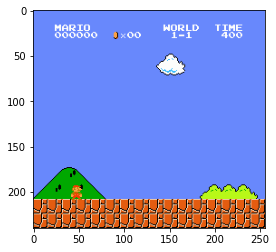

0.0 False {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


In [6]:
obs, reward, done, details = env.step(action=0)
plt.imshow(obs)
plt.show()
print(reward, done, details)

#Rendering Frames
Converting env frames to grayscale and resizing it to (1, 84, 84) using wrappers.

FrameStack Wrapper helps in combining frames.

In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total += reward
            if done:
                break
        return obs, total, done, info


class GrayScale(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class Resize(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScale(env)
env = Resize(env, shape=84)
env = FrameStack(env, num_stack=4)

MarioVLG
--------------

Using the `DDQN algorithm`.
It uses two ConvNets - $Q_{Train}$ and
$Q_{target}$.
The features are shared across
$Q_{Train}$ and $Q_{target}$, but separate FC
classifiers are maintained. To achieve this, the parameters of
$Q_{target}$ is frozen to prevent updation by backprop. And
is periodically synced with the parameters of
$Q_{Train}$

In [8]:
class MarioVLG(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.Train = nn.Sequential(
            nn.Conv2d(in_channels=input_dim[0], out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.Train)

        # Q_target parameters are frozen.
        for x in self.target.parameters():
            x.requires_grad = False

    def forward(self, input, model):
        if model == "Train":
            return self.Train(input)
        elif model == "target":
            return self.target(input)

In [9]:
# Complete body of Mario (includes what action to take, remember experiences, and updates Network)
class Mario:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir
        self.use_cuda = torch.cuda.is_available()
        self.net = MarioVLG(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 1e5
        
        self.memory = deque(maxlen=100000)
        self.batch_size = 32
        self.gamma = 0.9
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()
        self.burnin = 5000  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_Train
        self.sync_every = 5000  # no. of experiences between Q_target & Q_Train sync


    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(self.action_dim)
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="Train")
            action = torch.argmax(action_values, axis=1).item()

        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.curr_step += 1
        return action
        
    def cache(self, state, next_state, action, reward, done):
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

        
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="Train")[
            np.arange(0, self.batch_size), action
        ]
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="Train")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
        

    def update_Q_Train(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.Train.state_dict())
        
    def save(self):
        save_path = (
            self.save_dir / f"mario_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()
        if self.curr_step % self.save_every == 0:
            self.save()
        if self.curr_step < self.burnin:
            return None, None
        if self.curr_step % self.learn_every != 0:
            return None, None
        state, next_state, action, reward, done = self.recall()
        td_est = self.td_estimate(state, action)
        td_tgt = self.td_target(reward, next_state, done)
        loss = self.update_Q_Train(td_est, td_tgt)

        return (td_est.mean().item(), loss)

Training
--------------

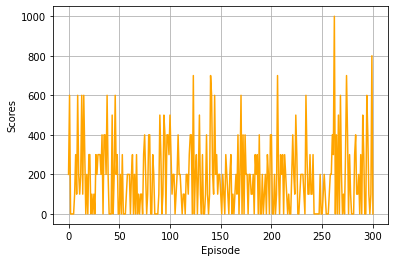

In [10]:
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = Mario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

episodes = 300
ep = []
scores = []
for e in range(episodes):
    tot_reward = 0
    score = 0

    state = env.reset()
    while True:
        action = mario.act(state)
        obs, reward, done, info = env.step(action)
        #plt.imshow(obs[3])
        #plt.show()
        mario.cache(state, obs, action, reward, done)
        q, loss = mario.learn()
        state = obs
        score=info["score"]
        if done or info["flag_get"]:
            break
    ep.append(e)
    scores.append(score)
    clear_output(wait=True)
    plt.xlabel("Episode")
    plt.ylabel("Scores")
    plt.plot(ep, scores, color = "orange")
    plt.grid()
    plt.show()

With number of episodes the peak scores have begun to rise. But for good results large number of games have to be played.